# Nonlinearities

In [ ]:
!apt install neofetch

In [ ]:
!neofetch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


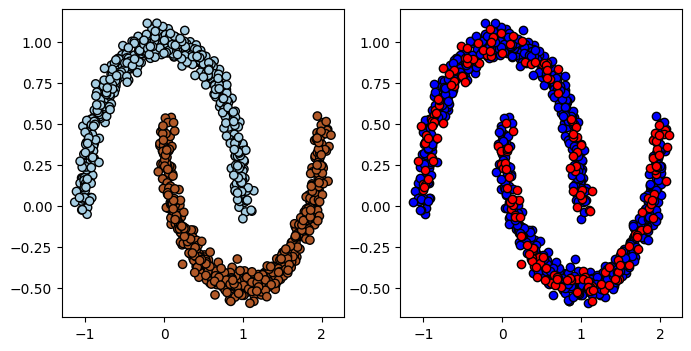

In [ ]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples = 1000 , noise=0.05)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(8,4))

axes[0].scatter( X[:, 0] , X[:, 1] , c = y , edgecolors='k', cmap='Paired')
axes[1].scatter( X_train[:, 0] , X_train[:, 1] , c="b", edgecolors='k')
axes[1].scatter( X_test [:, 0] , X_test [:, 1] , c="r", edgecolors='k')

In [ ]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [ ]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test , num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [ ]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


## Create a graph model

In [ ]:
model = nn.Sequential(
    nn.Linear(2 , 10), nn.ReLU(), #nn.ReLU(),
    nn.Linear(10, 10), nn.ReLU(),#nn.ReLU(),
    nn.Linear(10, 10), nn.ReLU(),#nn.ReLU(),
    nn.Linear(10, 10), nn.ReLU(),#nn.ReLU(),
    nn.Linear(10, 10), nn.ReLU(),#nn.ReLU(),
    nn.Linear(10, 10), nn.ReLU(),
    nn.Linear(10, 2), nn.Sigmoid()
)

model.cuda()
summary(model, input_size=(2,) , device = 'cuda' ) # device = 'cpu'
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
              ReLU-6                   [-1, 10]               0
            Linear-7                   [-1, 10]             110
              ReLU-8                   [-1, 10]               0
            Linear-9                   [-1, 10]             110
             ReLU-10                   [-1, 10]               0
           Linear-11                   [-1, 10]             110
             ReLU-12                   [-1, 10]               0
           Linear-13                    [-1, 2]              22
          Sigmoid-14                   

## Define loss function and optimizer

In [ ]:
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)

loss.cuda()

MSELoss()

## Train model

In [ ]:
epochs = 800
batch_size = 200
losses = []

progress = tqdm(range(epochs), ncols=110)

for epoch in progress :
  #
  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32).cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32).cuda()

    # 1. Zero the gradients
    optimizer.zero_grad()

    # 2. Perform forward pass
    predictions = model( batch_X ) # model.forward()

    # 3. Compute loss
    batch_loss = loss( batch_y , predictions )

    # 4. Perform backward pass
    batch_loss.backward()

    # 5. Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()

  progress.set_description("Epoch [%d/%d] [Loss: %f]" % (epoch, epochs,
                                                         batch_losses/(len(X_train)/batch_size)))

  losses.append(batch_losses/(len(X_train)/batch_size))


Epoch [799/800] [Loss: 0.000173]: 100%|█████████████████████████████████████| 800/800 [00:10<00:00, 75.51it/s]


## Plot results

Text(0, 0.5, 'Loss (MSE)')

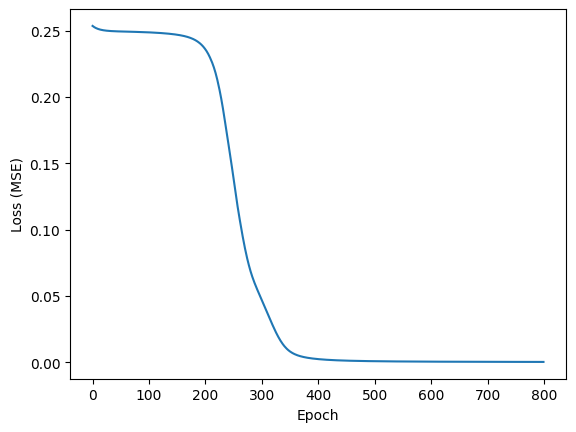

In [ ]:
# import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")
plt.ylabel('Loss (MSE)')

In [ ]:
h_min, h_max = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
v_min, v_max = X_test[:, 1].min()-0.1, X_test[:, 1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 300), np.linspace( v_min , v_max , 300))

# Predecir los valores del grid
grid_ = torch.from_numpy( np.c_[h_grid.ravel(), v_grid.ravel()] ).to(torch.float32).cuda()
predictions = model( grid_ )
predictions = np.argmax( predictions.detach().cpu().numpy() , axis=1)
print (predictions.shape)

# Encajar las predicciones al tamaño del grid
predictions = predictions.reshape(h_grid.shape)
print (h_grid.shape, v_grid.shape, predictions.shape)

(90000,)
(300, 300) (300, 300) (300, 300)


[]

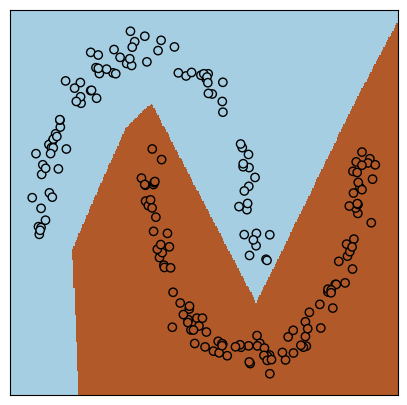

In [ ]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
ax.pcolormesh( h_grid , v_grid , predictions , cmap='Paired')

ax.scatter( X_test[:, 0] , X_test[:, 1] , c = np.argmax(y_test, axis=1), edgecolors='k', cmap='Paired')

# ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
# ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())